# Data Wrangling

#### On this notebook, I am taking the necessary data, and organize it to complete my last project. I am doing a times series analysis for three different stocks traded in the New York Stock Exchange. I am doing the analysis to Apple, American Airlines, and Tesla. Additionally, to make this project more advanced, I am studying the correlation between those stock prices and the oil price. 

#### Firstly, I am importing the libraries we need to use to complete this step.

In [1]:
#Import libraries
import pandas as pd
from pandas_datareader.data import DataReader
import datetime
import functools
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose

## Data Wrangling

#### I want to use a code that is reusable in case I want to add any other stock to our analysis. 

I am using Data Reader to get the data from yahoo finance. This would give me the chance to get the data directly from the web without necessity of uploading any csv file. 

After getting the data, I will convert the data to data frame to make the data easier to use.

In [2]:
# Create a function that reads the data from yahoo finance
def stock_data(ticker, data_source, start, end):
    df = DataReader(ticker, data_source, start, end)['Adj Close']
    df = df.to_frame(ticker) 
    return df

In [3]:
#Define variables of data source, start and end date
start = datetime.date(2000,1,1)
end = datetime.date(2020,8,31)
source = 'yahoo'

In [4]:
#Get the data from the stocks we would like to make the data serie analysis. In this case, Apple, American Airlines and Tesla
aapl = stock_data('AAPL', source, start, end)
aal = stock_data('AAL', source, start, end)
tsla = stock_data('TSLA', source, start, end)

We downloaded the oil data from quandl. We could also use Data Reader with an API key. To get the data we use the function the pandas function read_csv.

In [5]:
#Read the oil price
oil = pd.read_csv('OPEC-ORB.csv', index_col = 0)
oil.index = pd.to_datetime(oil.index)
oil.rename( columns = {'Value': 'Oil Price'}, inplace = True)

We also want to create a reusable code to merge different data frames. 

In [6]:
# Define a function to merge the different data frames
def merge_df(df1, df2, df3, df4):
    df = [df1, df2, df3, df4]
    return functools.reduce(lambda left, right : pd.merge(left, right, how = 'inner', on = 'Date'), df)

In [7]:
#Data Frame we are going to make the times series
df = merge_df(oil, aapl, aal, tsla).sort_values(by = 'Date', ascending = True)

## Data Frame overview

#### I am exploring the data we have to see if it is necessary to drop/replace Null-Values.

In [8]:
#Info function on the data frame
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2559 entries, 2010-06-29 to 2020-08-31
Data columns (total 4 columns):
Oil Price    2559 non-null float64
AAPL         2559 non-null float64
AAL          2559 non-null float64
TSLA         2559 non-null float64
dtypes: float64(4)
memory usage: 100.0 KB


In [9]:
#Check if there is NaN values
#There are no Null-Values
df.isna().sum()

Oil Price    0
AAPL         0
AAL          0
TSLA         0
dtype: int64

In [10]:
# See the first 5 heads
df.head(n = 5)

,Oil Price,AAPL,AAL,TSLA
Date,,,,
2010-06-29,72.66,7.905947,8.051013,4.778
2010-06-30,72.49,7.762749,8.117004,4.766
2010-07-01,70.48,7.668618,8.154712,4.392
2010-07-02,69.63,7.621089,7.721052,3.840
2010-07-06,69.73,7.673245,7.617351,3.222


## Data Visualization

On this step I want to see the stock behavior during time. I am also doing correlation hetmaps to see how the stocks move in relation with the oil price. Additionally, I am plotting autocorrelation graphics to know the order of the ARIMA or SARIMAX model. Finally, I am doing a seasonal decompose to see trend, seasonality of the data I got.  

### Plot the Multiple times series 

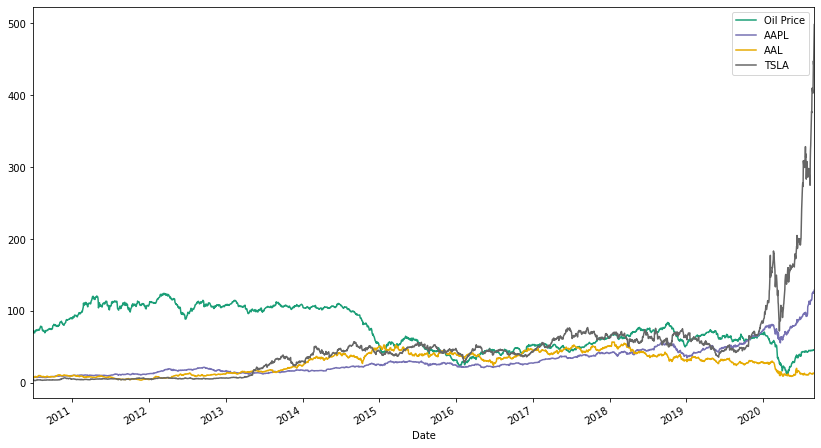

In [11]:
#Plot 
df.plot(cmap = 'Dark2', figsize = (14,8))
plt.legend(loc = 'best')
plt.show()

From the graphic above, we can see after 2019, Tesla stock dramatically increased its value over time. Right now, we could think Tesla stock would continue increasing the stock price for the momentum. Additionally, the oul price has fallen after 2015 (this because fracking was implemented and the majorist productors started competing with low price). For the correlation heatmap, we may use only the data available after 2019 to see the relation between oil and stock price recently and not being influenced by previous activities when oil price was really high and for example, Tesla stock was just on their beginning and the stock price was really low. 

### Correlation among the stocks and the oil price

In [12]:
#Define the function to create the correlation matrix
def correlation_matrix(df, method):
    return df.corr(method = method)

In [13]:
#Define the function for the correlation heatmap
def correlation_matrix_heatmap(df, method):
    return sns.heatmap(df.corr(method = method))

In [14]:
# To create the correlation heatmap, we are using the data from 2019 to the present. 
# Tesla and Apple Stock increased their value dramatically, so this may badly influence our insights
df_corr = df.loc['2019-01-01':]

#### Pearson Correlation

In [15]:
#Correlation Matrix
correlation_matrix(df_corr, 'pearson')

,Oil Price,AAPL,AAL,TSLA
Oil Price,1.000000,-0.491929,0.894232,-0.532762
AAPL,-0.491929,1.000000,-0.732580,0.921074
AAL,0.894232,-0.732580,1.000000,-0.730361
TSLA,-0.532762,0.921074,-0.730361,1.000000


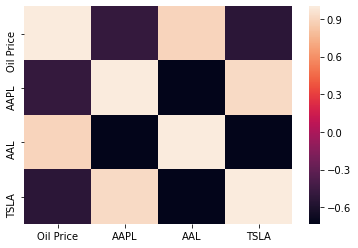

In [16]:
#Correlation heatmap
correlation_matrix_heatmap(df_corr, 'pearson')

#### Kendall Correlation

In [17]:
#Correlation Matrix
correlation_matrix(df_corr, 'kendall')

,Oil Price,AAPL,AAL,TSLA
Oil Price,1.000000,-0.324071,0.578669,-0.378112
AAPL,-0.324071,1.000000,-0.536638,0.622721
AAL,0.578669,-0.536638,1.000000,-0.399332
TSLA,-0.378112,0.622721,-0.399332,1.000000


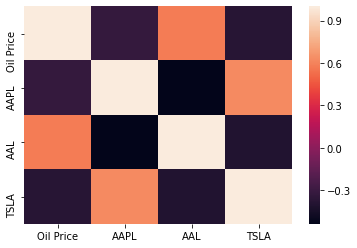

In [18]:
#Correlation Heatmap
correlation_matrix_heatmap(df_corr, 'kendall')

#### Spearman Correlation

In [19]:
#Correlation Matrix
correlation_matrix(df_corr, 'spearman')

,Oil Price,AAPL,AAL,TSLA
Oil Price,1.000000,-0.547626,0.776885,-0.626441
AAPL,-0.547626,1.000000,-0.764224,0.808118
AAL,0.776885,-0.764224,1.000000,-0.619296
TSLA,-0.626441,0.808118,-0.619296,1.000000


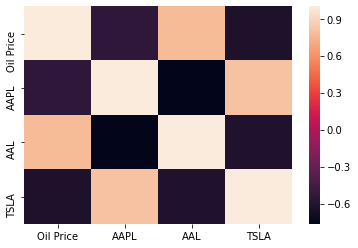

In [20]:
#Correlation Heatmap
correlation_matrix_heatmap(df_corr, 'spearman')

#### Insights from the correlation matrix

- As expected, Tesla stock is the less correlated with the oil price and American Airlines the most correlated with the oil price.


- Regarding the correlation result for American Airlines, we have a following hypothesis: If there is an increase on the oil price is because the increase of the demand. People around the world are transportating, so there is more customers on the airline industry, so therefore an increase on its revenues. If the company does well, investors acquire stocks, and therefore stock price also increases.


- For Tesla we have the following hypothesis: Oil prices roses the lowest value in their history. Tesla on the other hand, they have their highest stock price. To remark, oil prices are down and Tesla stock prices are high, so that's why we can support their negative correlation.  Same can be explained with Apple. 


- In the future, we could have the following hypothesis to what is going to happen between Tesla and its stock price: Oil prices could continue going down due to the use of fraking. People may not see Tesla as savings to their budget since it would be cheaper to just continue using regular gas, thereby Tesla revenues would go down and therefore their stock price as well. On the other hand, people will to make the world more ecological can continue increasing Tesla revenues and therefore their stock price.

### Autocorrelation

In [21]:
#Define a data frame with the rate of return of the stocks and if the oil price increased, decreased or was the same
df_change = df.pct_change().dropna()

In [22]:
df_change.head(n = 5)

,Oil Price,AAPL,AAL,TSLA
Date,,,,
2010-06-30,-0.002340,-0.018113,0.008197,-0.002512
2010-07-01,-0.027728,-0.012126,0.004645,-0.078472
2010-07-02,-0.012060,-0.006198,-0.053179,-0.125683
2010-07-06,0.001436,0.006844,-0.013431,-0.160938
2010-07-07,0.000143,0.040382,0.153466,-0.019243


In [23]:
## Define a function that plots the autocorrelation
def plot_autocorrelation(x, lags, alpha):
    fig = plot_acf(x, lags = lags, alpha = alpha)
    return plt.show()

#### Oil Price

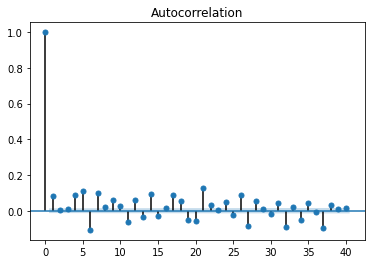

In [24]:
plot_autocorrelation(df_change['Oil Price'], lags = 40, alpha = 0.5)

#### Apple

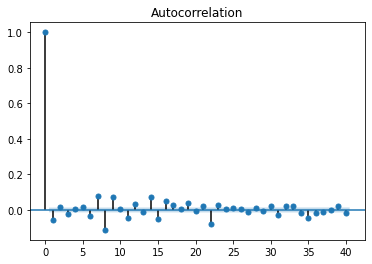

In [25]:
plot_autocorrelation(df_change['AAPL'], lags = 40, alpha = 0.5)

#### Tesla

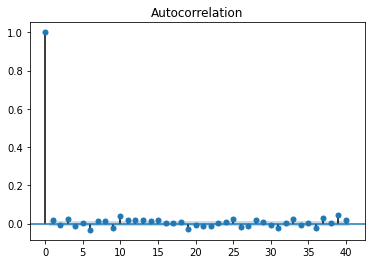

In [26]:
plot_autocorrelation(df_change['TSLA'], lags = 40, alpha = 0.5)

#### AAL

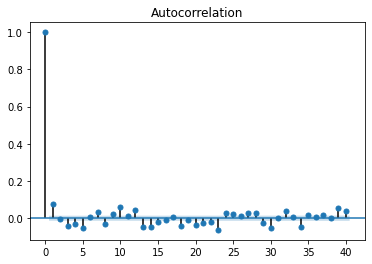

In [27]:
plot_autocorrelation(df_change['AAL'], lags = 40, alpha = 0.5)

#### Key Insights

- From the autocorrelation plots,we may conclude that all the stocks and also the oil price is order 1.

### Decomposition Analysis

In [28]:
def decomposition_analysis(x, model, freq):
    return seasonal_decompose(x = x , model = model , freq = freq)

In [29]:
#Apply the function for the columns
stock_columns = list(df.columns)
stocks_decompose = []
trends = []
seasonals = []
residuals = []
observeds = []

for stock in stock_columns:
    #Decomposition
    decomposition = decomposition_analysis(x = df[stock], model = 'multiplicative', freq = 252)
    stocks_decompose.append(decomposition)
    
    #Trend
    trend = decomposition.trend
    trends.append(trend)
    
    #Seasonal
    seasonal = decomposition.seasonal
    seasonals.append(seasonal)
    
    #Residual
    residual = decomposition.resid
    residuals.append(residual)
    
    #Observed
    observed = decomposition.observed
    observeds.append(observed)

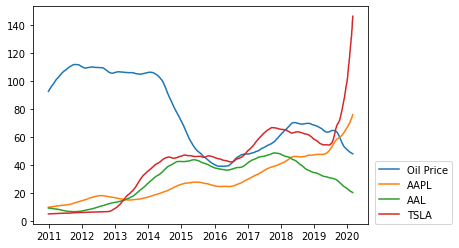

In [30]:
#Plot the trend for the stocks
for i, j in enumerate(stock_columns):
    plt.plot(trends[i], label = j)
    plt.legend(loc = (1.02, 0))
    continue

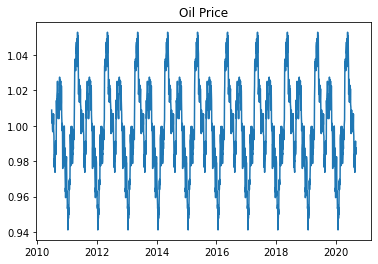

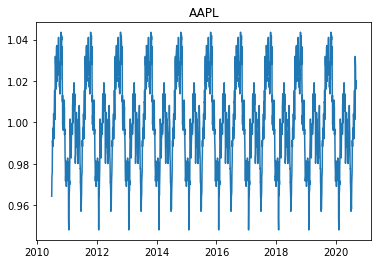

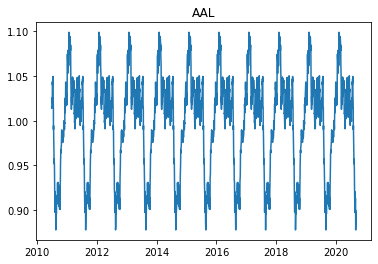

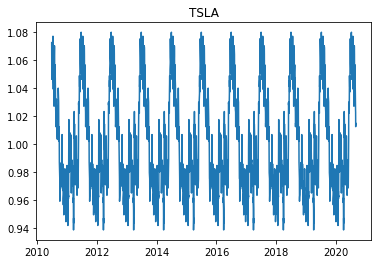

In [31]:
#Plot the seasonals for stocks
for i, j in enumerate(stock_columns):
    plt.plot(seasonals[i])
    plt.title(j)
    plt.show()

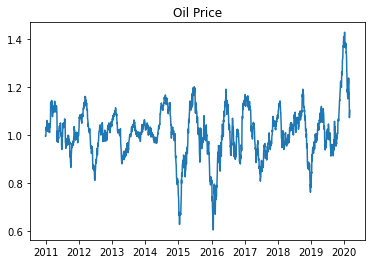

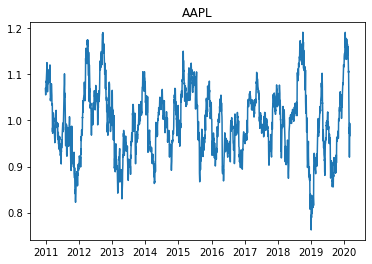

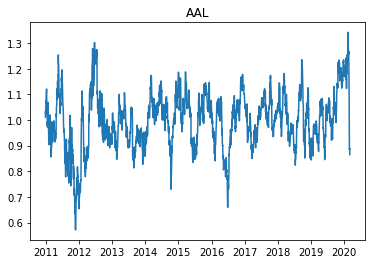

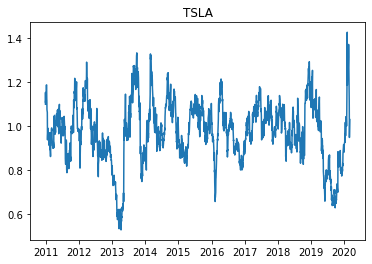

In [32]:
#Plot the residuals for each stock
for i, j in enumerate(stock_columns):
    plt.plot(residuals[i])
    plt.title(j)
    plt.show()
    continue

From the graphics, I concluded that Oil Price is very volatile, but the overall trend is to decrease.


For American Airlines, it was increasing its stock price, but recently their stock is going down as well. 


Finally, for Apple and Tesla, they have been increasing their stock value during time, and it is remarkable that Tesla increased dramatically its stock price during 2019. On the other hand, Apple increase has been more gradually than Tesla. 

Stocks more similarly regarding their stationarity and all of the stocks have similar value on their residuals as well.